In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as Dataset
import torchvision.transforms as Transforms
import matplotlib.pyplot as plt
from tqdm import tqdm


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [75]:
NUM_EPOCH = 5
NUM_CLASSES = 47
BATCH_SIZE = 64
LEARNING_RATE = 0.01

### Dataset

In [76]:
#Download the dataset
train_dataset = Dataset.EMNIST(root="./data", train=True, transform=Transforms.ToTensor(), split="balanced", download=True)
test_dataset = Dataset.EMNIST(root="./data", train=False, transform=Transforms.ToTensor(), split="balanced", download=True)

In [77]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [78]:
# Normalize the dataset
mean = 0.0
std = 0.0
num_samples = 0


for data, lbls in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print(f'{mean=}; {std=}; {num_samples=}')

normalize_transform = Transforms.Normalize(mean=mean, std=std)

train_loader.transform = Transforms.Compose([
    Transforms.ToTensor(),
    normalize_transform
])

test_loader.transform = Transforms.Compose([
    Transforms.ToTensor(),
    normalize_transform
])



mean=tensor([0.1751]); std=tensor([0.3267]); num_samples=112800


In [79]:
mean = [0.1751]
std = [0.3267]
num_samples=112800

In [80]:
for data, label in train_loader:
    print("Data shape:", data.shape)
    
    print("Label:", label)
    break

Data shape: torch.Size([64, 1, 28, 28])
Label: tensor([ 8, 20, 31, 29, 32, 40, 34, 36, 21, 22,  0, 41, 39,  7,  7, 23, 32, 25,
        17, 43,  2, 17, 22, 14, 12, 41, 46, 39, 24, 44, 34,  1, 25, 33,  0, 37,
        41, 26,  3, 19, 27,  0,  0, 27, 17, 20, 25, 29, 41, 12, 18,  2, 36, 44,
        28, 40, 10, 29, 11, 36, 13,  8,  6, 21])


number of classes 47


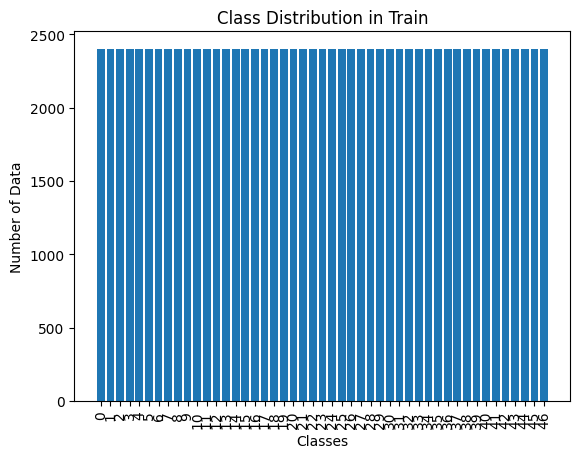

In [81]:
class_counts = {}

for values, labels in train_loader:
    for label in labels:
        if label.item() in class_counts:
            class_counts[label.item()] += 1
        else:
            class_counts[label.item()] = 1

classes = list(class_counts.keys())
counts = list(class_counts.values())
print(f'number of classes {len(classes)}')
NUM_CLASSES = len(classes)

# Plotting graph
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Data')
plt.title('Class Distribution in Train')
plt.xticks(classes)
plt.xticks(rotation=90)
plt.show()

In [82]:
VGG16 = [64, 64, 'M', 128,128,'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
VGG1 = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M']

In [83]:
class VGGNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, architecture=VGG16):
        super(VGGNet, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layer(VGG16)
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096), # size of feature map at end is 7*7
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096,num_classes)
        )
        self.softMax = nn.Softmax(dim=1) # not sure


    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fcs(out)
        out = self.softMax(out)
        return out

    def create_conv_layer(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3),stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)
        


In [90]:
class VGGNet1(nn.Module):
    def __init__(self, in_channels=1, num_classes=1000, architecture=VGG1):
        super(VGGNet1, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layer(architecture)
        self.fcs = nn.Sequential(
            nn.Linear(2304, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(2048,num_classes)
        )
        self.softMax = nn.Softmax(dim=1)


    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fcs(out)
        out = self.softMax(out)
        return out

    def create_conv_layer(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3),stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)
        


In [91]:
model = VGGNet1(architecture=VGG1,in_channels=1, num_classes=NUM_CLASSES).to(device)
model

VGGNet1(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

In [92]:
def test():
    x = torch.randn(2, 1, 28, 28)
    print(x.shape)

    result = model(x.to(device))
    return result

fp = test()
fp

torch.Size([2, 1, 28, 28])


tensor([[0.0637, 0.0250, 0.0195, 0.0130, 0.0213, 0.0249, 0.0179, 0.0386, 0.0142,
         0.0222, 0.0125, 0.0174, 0.0218, 0.0165, 0.0315, 0.0142, 0.0237, 0.0132,
         0.0204, 0.0166, 0.0147, 0.0258, 0.0287, 0.0128, 0.0255, 0.0283, 0.0236,
         0.0147, 0.0192, 0.0184, 0.0186, 0.0237, 0.0247, 0.0189, 0.0164, 0.0193,
         0.0203, 0.0238, 0.0296, 0.0209, 0.0235, 0.0180, 0.0204, 0.0166, 0.0155,
         0.0149, 0.0153],
        [0.0274, 0.0225, 0.0219, 0.0141, 0.0300, 0.0251, 0.0210, 0.0250, 0.0297,
         0.0140, 0.0196, 0.0269, 0.0162, 0.0194, 0.0229, 0.0175, 0.0225, 0.0147,
         0.0195, 0.0174, 0.0245, 0.0224, 0.0261, 0.0190, 0.0169, 0.0264, 0.0206,
         0.0184, 0.0177, 0.0145, 0.0252, 0.0187, 0.0163, 0.0245, 0.0210, 0.0257,
         0.0161, 0.0250, 0.0201, 0.0231, 0.0163, 0.0267, 0.0202, 0.0233, 0.0172,
         0.0295, 0.0174]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [93]:
def train(model, epochs, criterion, optimizer, scheduler, train_loader, test_loader):

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []

    for i in range(epochs):
        running_loss = 0.0
        running_correct = 0
        total = 0
        best_acc = 0.0

        print(f"Epoch: {i + 1}")

        for images, targets in tqdm(train_loader, desc= "Train\t"):
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
            
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)
            
        scheduler.step()

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(running_correct / total)

        running_test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():

            for images, targets in tqdm(test_loader, desc= "Test\t"):
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_test_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            test_acc.append(acc)
            test_losses.append(running_test_loss / len(test_loader))

        if test_acc[-1] > best_acc:
            best_acc = test_acc[-1]
            torch.save(model.state_dict(), './models/model.pth') 

        print(f"Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}\n")


    return train_losses, train_acc, test_losses, test_acc
            

In [94]:
# optimizer and loss and scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH, eta_min=0.001)

In [95]:
train_losses, train_acc, test_losses, test_acc = train(model,NUM_EPOCH,criterion,optimizer,scheduler, train_loader, test_loader )

Epoch: 1


Test	: 100%|██████████| 294/294 [00:01<00:00, 164.62it/s]


Train Loss: 3.865, Train Acc: 0.021, Test Loss: 3.865, Test Acc: 0.021

Epoch: 2


Test	: 100%|██████████| 294/294 [00:01<00:00, 165.55it/s]


Train Loss: 3.865, Train Acc: 0.021, Test Loss: 3.865, Test Acc: 0.021

Epoch: 3


Test	: 100%|██████████| 294/294 [00:01<00:00, 159.25it/s]


Train Loss: 3.865, Train Acc: 0.021, Test Loss: 3.865, Test Acc: 0.021

Epoch: 4


Test	: 100%|██████████| 294/294 [00:01<00:00, 165.99it/s]


Train Loss: 3.865, Train Acc: 0.021, Test Loss: 3.865, Test Acc: 0.021

Epoch: 5


Test	: 100%|██████████| 294/294 [00:01<00:00, 162.41it/s]

Train Loss: 3.865, Train Acc: 0.021, Test Loss: 3.865, Test Acc: 0.021

